In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')


In [6]:
df = pd.read_csv("phishing.csv")
print("Shape:", df.shape)
print("Head:")
print(df.head())


Shape: (11054, 32)
Head:
   Index  UsingIP  LongURL  ShortURL  Symbol@  Redirecting//  PrefixSuffix-  \
0      0        1        1         1        1              1             -1   
1      1        1        0         1        1              1             -1   
2      2        1        0         1        1              1             -1   
3      3        1        0        -1        1              1             -1   
4      4       -1        0        -1        1             -1             -1   

   SubDomains  HTTPS  DomainRegLen  ...  UsingPopupWindow  IframeRedirection  \
0           0      1            -1  ...                 1                  1   
1          -1     -1            -1  ...                 1                  1   
2          -1     -1             1  ...                 1                  1   
3           1      1            -1  ...                -1                  1   
4           1      1            -1  ...                 1                  1   

   AgeofDomain  DNS

In [26]:
print("Missing values:\n", df.isnull().sum())

X = df.drop(['Index','class'], axis=1)
y = df['class']


Missing values:
 Index                  0
UsingIP                0
LongURL                0
ShortURL               0
Symbol@                0
Redirecting//          0
PrefixSuffix-          0
SubDomains             0
HTTPS                  0
DomainRegLen           0
Favicon                0
NonStdPort             0
HTTPSDomainURL         0
RequestURL             0
AnchorURL              0
LinksInScriptTags      0
ServerFormHandler      0
InfoEmail              0
AbnormalURL            0
WebsiteForwarding      0
StatusBarCust          0
DisableRightClick      0
UsingPopupWindow       0
IframeRedirection      0
AgeofDomain            0
DNSRecording           0
WebsiteTraffic         0
PageRank               0
GoogleIndex            0
LinksPointingToPage    0
StatsReport            0
class                  0
dtype: int64


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
import os

# Step 1: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X should have 30 features only

# Step 2: Apply PCA
pca = PCA(n_components=16)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Save both objects
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(pca, "models/pca.pkl")

print("✅ Scaler and PCA saved successfully.")


✅ Scaler and PCA saved successfully.


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [29]:
ann_model = Sequential()
ann_model.add(Dense(6, activation='relu', input_dim=16))
ann_model.add(Dense(6, activation='relu'))
ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train, y_train, epochs=20, batch_size=10, verbose=1)

ann_model.save("models/ann_model.h5")


Epoch 1/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7053 - loss: 0.5956
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9086 - loss: 0.2399
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9204 - loss: 0.2002
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9206 - loss: 0.1950
Epoch 5/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9304 - loss: 0.1746
Epoch 6/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9310 - loss: 0.1820
Epoch 7/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9296 - loss: 0.1796
Epoch 8/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9301 - loss: 0.1806
Epoch 9/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9258 - loss: 0.1835
Epoch 10/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9304 - loss: 0.1713
Epoch 11/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9253 - loss: 0.1817
Epoch 12/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/s

In [30]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, "models/rf_model.pkl")


['models/rf_model.pkl']

In [31]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
joblib.dump(svm_model, "models/svm_model.pkl")


['models/svm_model.pkl']

In [32]:
# ANN
ann_probs = ann_model.predict(X_test).flatten()
ann_pred = ann_probs > 0.5
ann_auc = roc_auc_score(y_test, ann_probs)
print("ANN AUC:", ann_auc)

# RF
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_pred = rf_probs > 0.5
rf_auc = roc_auc_score(y_test, rf_probs)
print("Random Forest AUC:", rf_auc)

# SVM
svm_probs = svm_model.predict_proba(X_test)[:, 1]
svm_pred = svm_probs > 0.5
svm_auc = roc_auc_score(y_test, svm_probs)
print("SVM AUC:", svm_auc)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ANN AUC: 0.9829644255658061
Random Forest AUC: 0.990242334240393
SVM AUC: 0.9857544633968276


In [ ]:

ann_probs = ann_model.predict(X_test).flatten()
ann_pred = ann_probs > 0.5
ann_auc = roc_auc_score(y_test, ann_probs)
print("ANN AUC:", ann_auc)


rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_pred = rf_probs > 0.5
rf_auc = roc_auc_score(y_test, rf_probs)
print("Random Forest AUC:", rf_auc)


svm_probs = svm_model.predict_proba(X_test)[:, 1]
svm_pred = svm_probs > 0.5
svm_auc = roc_auc_score(y_test, svm_probs)
print("SVM AUC:", svm_auc)


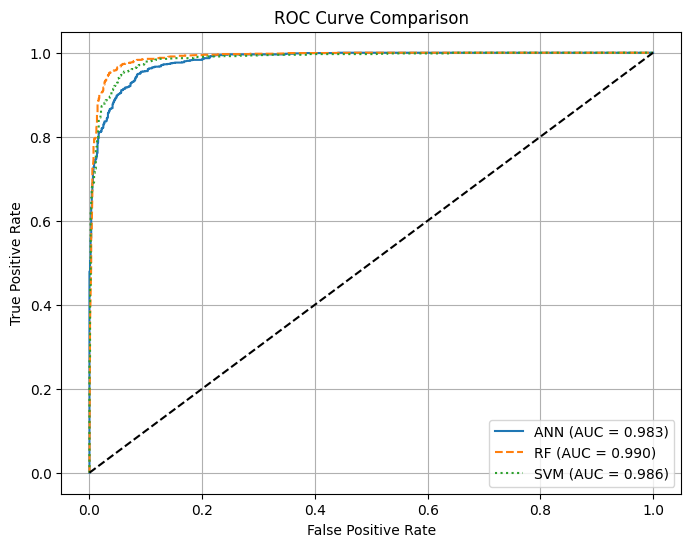

In [33]:
fpr_ann, tpr_ann, _ = roc_curve(y_test, ann_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, label=f"ANN (AUC = {ann_auc:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC = {rf_auc:.3f})", linestyle='--')
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {svm_auc:.3f})", linestyle=':')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


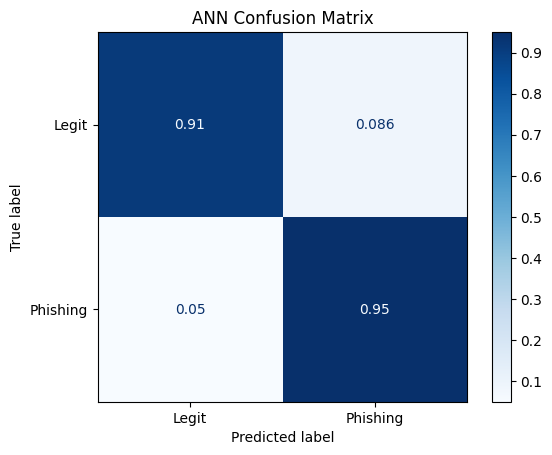

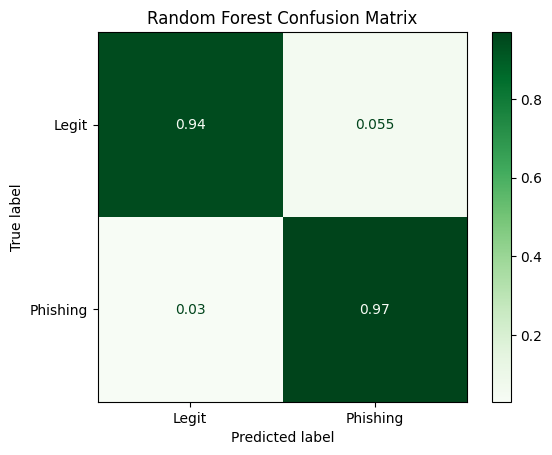

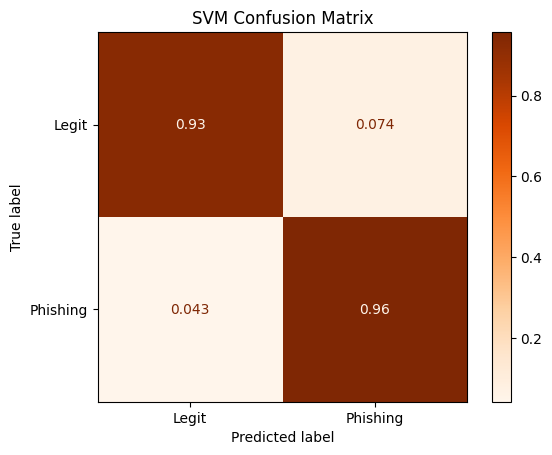

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

# ANN Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, ann_pred, display_labels=['Legit', 'Phishing'], cmap='Blues', normalize='true')
plt.title("ANN Confusion Matrix")
plt.show()

# Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, display_labels=['Legit', 'Phishing'], cmap='Greens', normalize='true')
plt.title("Random Forest Confusion Matrix")
plt.show()

# SVM Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, svm_pred, display_labels=['Legit', 'Phishing'], cmap='Oranges', normalize='true')
plt.title("SVM Confusion Matrix")
plt.show()



In [35]:
from sklearn.metrics import classification_report

print("🔸 ANN Classification Report:\n", classification_report(y_test, ann_pred))
print("🔸 Random Forest Classification Report:\n", classification_report(y_test, rf_pred))
print("🔸 SVM Classification Report:\n", classification_report(y_test, svm_pred))


🔸 ANN Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       976
           1       0.93      0.95      0.94      1235

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211

🔸 Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       976
           1       0.96      0.97      0.96      1235

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211

🔸 SVM Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       976
           1       0.94      0.96      0.95      1235

    accuracy                           0.94      2211
   macro avg       0.94     

In [36]:
summary = {
    'Model': ['ANN', 'Random Forest', 'SVM'],
    'AUC Score': [ann_auc, rf_auc, svm_auc],
    'Accuracy (%)': [
        accuracy_score(y_test, ann_pred) * 100,
        accuracy_score(y_test, rf_pred) * 100,
        accuracy_score(y_test, svm_pred) * 100
    ]
}

summary_df = pd.DataFrame(summary)
print(summary_df)


           Model  AUC Score  Accuracy (%)
0            ANN   0.982964     93.396653
1  Random Forest   0.990242     95.884215
2            SVM   0.985754     94.346450


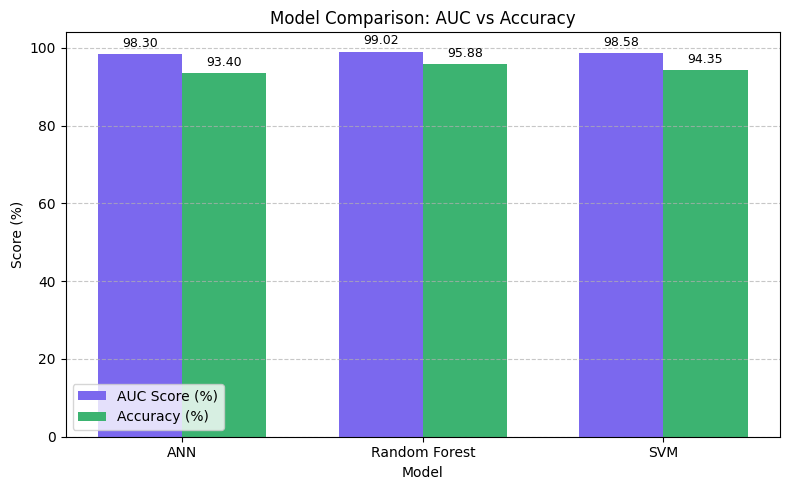

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = summary_df['Model']
auc_scores = summary_df['AUC Score']
accuracy_scores = summary_df['Accuracy (%)']

x = np.arange(len(models))  # label locations
width = 0.35  # width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, auc_scores * 100, width, label='AUC Score (%)', color='mediumslateblue')
bars2 = ax.bar(x + width/2, accuracy_scores, width, label='Accuracy (%)', color='mediumseagreen')

# Add text labels above bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

# Customizing
ax.set_xlabel('Model')
ax.set_ylabel('Score (%)')
ax.set_title('Model Comparison: AUC vs Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [38]:
X = df.drop('class', axis=1)


In [39]:
X = df.drop('class', axis=1)
y = df['class']

print(X.columns.tolist())


['Index', 'UsingIP', 'LongURL', 'ShortURL', 'Symbol@', 'Redirecting//', 'PrefixSuffix-', 'SubDomains', 'HTTPS', 'DomainRegLen', 'Favicon', 'NonStdPort', 'HTTPSDomainURL', 'RequestURL', 'AnchorURL', 'LinksInScriptTags', 'ServerFormHandler', 'InfoEmail', 'AbnormalURL', 'WebsiteForwarding', 'StatusBarCust', 'DisableRightClick', 'UsingPopupWindow', 'IframeRedirection', 'AgeofDomain', 'DNSRecording', 'WebsiteTraffic', 'PageRank', 'GoogleIndex', 'LinksPointingToPage', 'StatsReport']


In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics
precision = [
    precision_score(y_test, ann_pred),
    precision_score(y_test, rf_pred),
    precision_score(y_test, svm_pred)
]

recall = [
    recall_score(y_test, ann_pred),
    recall_score(y_test, rf_pred),
    recall_score(y_test, svm_pred)
]

f1 = [
    f1_score(y_test, ann_pred),
    f1_score(y_test, rf_pred),
    f1_score(y_test, svm_pred)
]

# Add to summary_df
summary_df["Precision"] = precision
summary_df["Recall"] = recall
summary_df["F1-Score"] = f1

# Show final summary
print("\n🔎 Final Model Performance Summary:")
print(summary_df)



🔎 Final Model Performance Summary:
           Model  AUC Score  Accuracy (%)  Precision    Recall  F1-Score
0            ANN   0.982964     93.396653   0.933174  0.949798  0.941413
1  Random Forest   0.990242     95.884215   0.956869  0.970040  0.963410
2            SVM   0.985754     94.346450   0.942584  0.957085  0.949779
